In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Classification Using CNN (first classify (potato))
By : Amira Fathy

________


Data link : https://www.kaggle.com/datasets/sadmansakibmahi/plant-disease-expert



In [2]:
## import libraries


In [3]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import keras
import pandas as pd
import os
import glob as gb
from zipfile import ZipFile

In [4]:
# the path of zip file
file_name=r'/content/drive/MyDrive/Potato.zip'

In [5]:
# extract zip file
with ZipFile(file_name,'r')as Zip:
  Zip.printdir()
  Zip.extractall()

File Name                                             Modified             Size
Potato/Potato___Early_blight/                  2022-03-05 16:34:04            0
Potato/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG 2019-11-14 05:40:24        20183
Potato/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG 2019-11-14 05:40:24        17224
Potato/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG 2019-11-14 05:40:24        21507
Potato/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG 2019-11-14 05:40:24        17949
Potato/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG 2019-11-14 05:40:24        19165
Potato/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG 2019-11-14 05:40:24        18469
Potato/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG 2019-11-14 05:40:24       

In [6]:
# path of image

data_path=r'/content/Potato'

In [7]:
# get the common size in images
# and the number of the images in each folder
size = []
for folder in  os.listdir(data_path) :
    files = gb.glob(pathname= str( data_path +'/'+ folder + '/*.JPG'))
    print(f' found  {len(files)}  images in folder {folder}')
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

 found  1000  images in folder Potato___Late_blight
 found  1000  images in folder Potato___Early_blight
 found  152  images in folder Potato___healthy


(256, 256, 3)    2152
dtype: int64

In [8]:
# initializing value
BATCH_SIZE = 128
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [9]:
# load images  by keras
dataset =tf.keras.preprocessing.image_dataset_from_directory(data_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
# class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(128, 256, 256, 3)
[1 1 1 0 0 0 1 1 1 1 0 0 1 2 1 1 1 1 0 1 0 2 0 0 0 0 0 0 2 1 1 0 1 0 0 0 1
 0 1 0 0 1 2 1 0 0 1 0 2 1 1 2 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1
 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 2 1 0 0 0 0 0 0 2 0
 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 2 0]


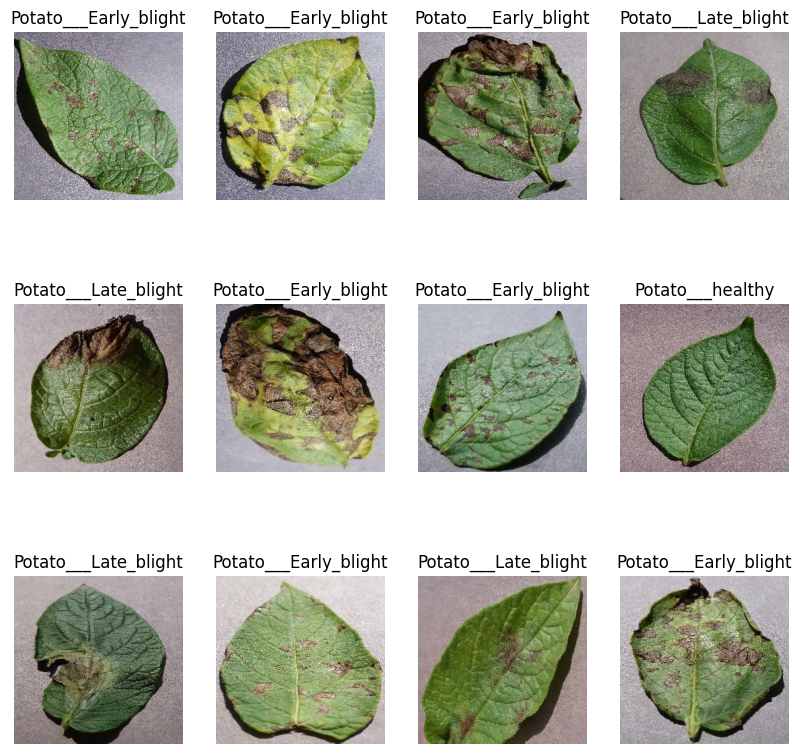

In [12]:
# show some of image
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
# len of  dataset
len(dataset)


17

In [14]:
#  function to split data (train , test, validation)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [15]:
# split data
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [16]:
len(train_ds),len(val_ds),len(test_ds)

(13, 1, 3)

In [17]:
# to use the cpu & gpu
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# normalization data
# resize & rescale
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


In [27]:
# data augmentation (ImageDataGenerator)
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [20]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [19]:
# bulid the CNN (Neural Network )
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(128, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 256, 256, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 254, 254, 128)      3584      
                                                                 
 max_pooling2d (MaxPooling2D  (128, 127, 127, 128)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (128, 125, 125, 64)       73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (128, 62, 62, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (128, 60, 60, 64)        

In [21]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
#train CNN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
13/13 [==============================] - 36s 1s/step - loss: 1.0242 - accuracy: 0.4811 - val_loss: 0.8367 - val_accuracy: 0.7344
Epoch 2/30
13/13 [==============================] - 6s 490ms/step - loss: 0.6702 - accuracy: 0.7720 - val_loss: 0.5328 - val_accuracy: 0.8047
Epoch 3/30
13/13 [==============================] - 6s 491ms/step - loss: 0.4602 - accuracy: 0.8366 - val_loss: 0.4736 - val_accuracy: 0.8203
Epoch 4/30
13/13 [==============================] - 6s 493ms/step - loss: 0.3077 - accuracy: 0.8878 - val_loss: 0.2988 - val_accuracy: 0.8750
Epoch 5/30
13/13 [==============================] - 6s 493ms/step - loss: 0.2354 - accuracy: 0.9104 - val_loss: 0.1934 - val_accuracy: 0.9141
Epoch 6/30
13/13 [==============================] - 6s 496ms/step - loss: 0.2140 - accuracy: 0.9183 - val_loss: 0.1705 - val_accuracy: 0.9375
Epoch 7/30
13/13 [==============================] - 6s 495ms/step - loss: 0.1091 - accuracy: 0.9695 - val_loss: 0.1259 - val_accuracy: 0.9375
Epoch 8/

In [23]:
# acuuracy of the test
scores = model.evaluate(test_ds)


3/3 [==============================] - 3s 151ms/step - loss: 0.1343 - accuracy: 0.9870


In [25]:
scores


[0.13434702157974243, 0.9869791865348816]

In [26]:
history

In [27]:
history.params


{'verbose': 1, 'epochs': 30, 'steps': 13}

In [28]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

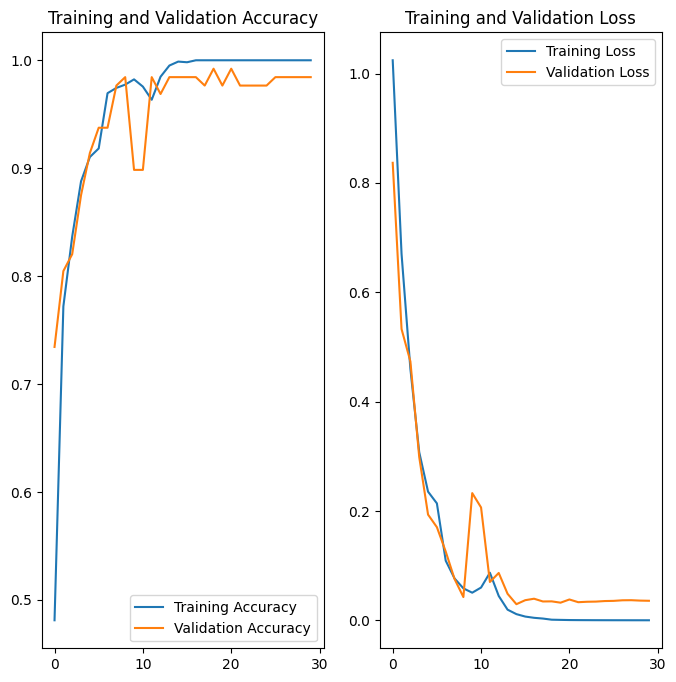

In [30]:
# show the  training & validation (accuracy & loss)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
4/4 [==============================] - 1s 30ms/step
predicted label: Potato___Early_blight


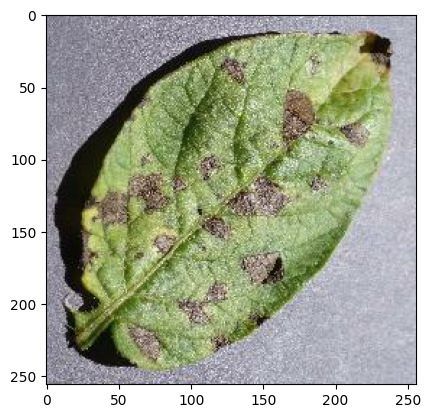

In [31]:
# the first image prdiction  vs the actual
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)

    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


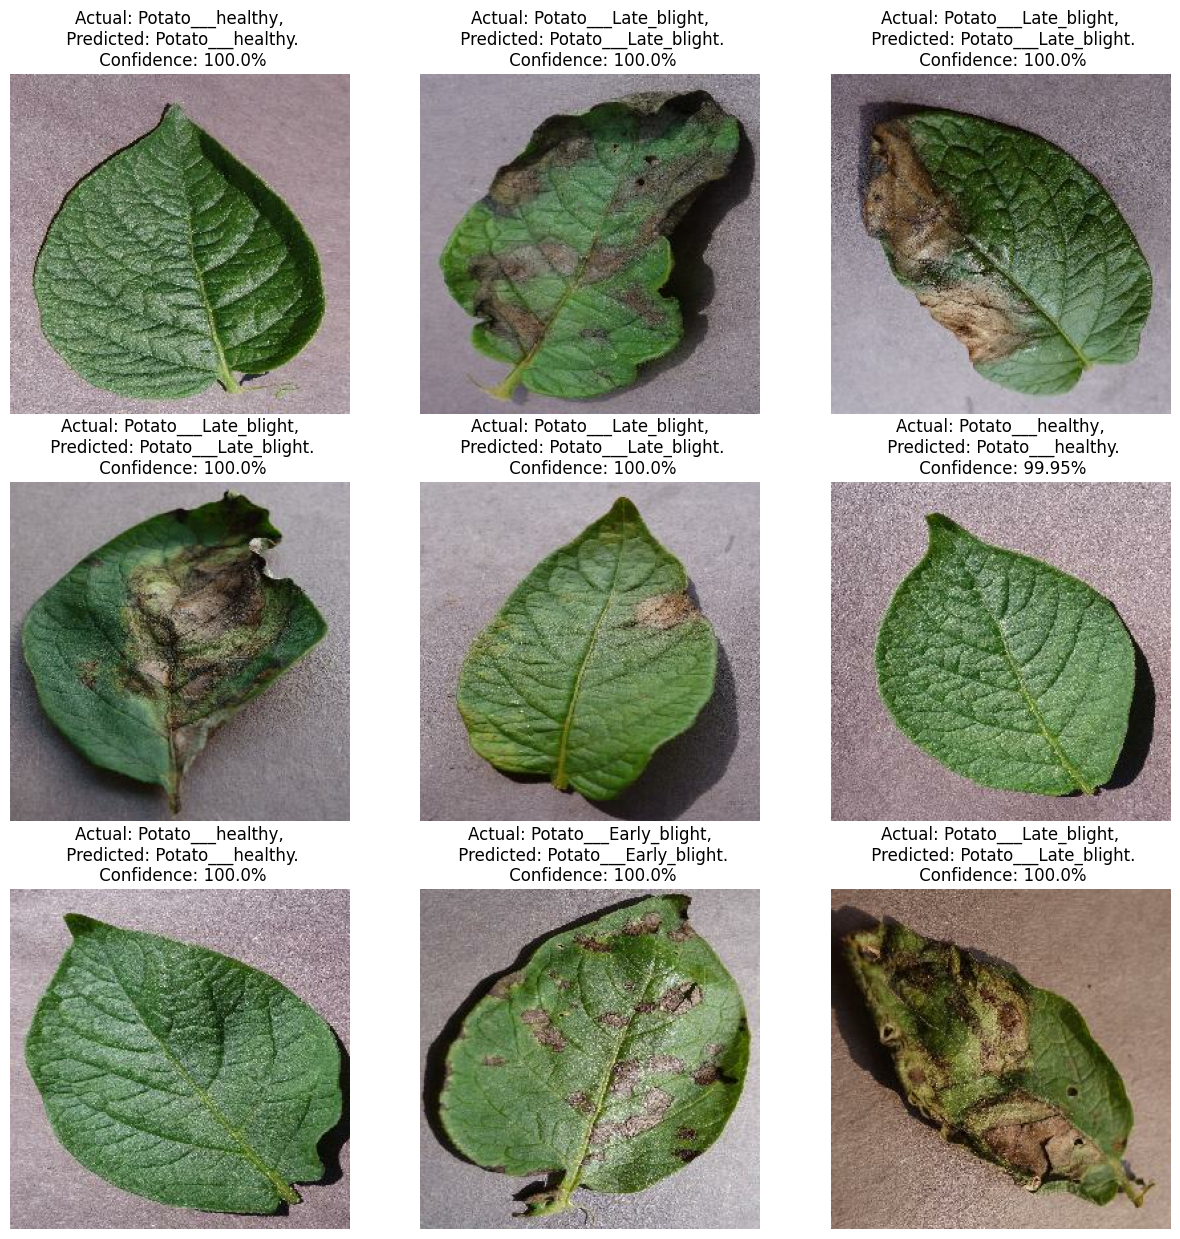

In [33]:
# show some of image  ( the prediction  vs actual )& the confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [34]:
# save model
model.save("potato_cnn.h5")